# Pitch Deck Dataset Data Cleaning

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

## Import Dataset

In [2]:
df = pd.read_csv('data/falory_clean_sectors.csv')

In [3]:
df.head()

,Name,Description,Sector,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,2,Marketplace,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,1,App,B2B,Series C,$54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,0,Subscription,B2B,Series A,$1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,3,SaaS,B2B,Seed,$2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...",5,Subscription,"B2C, B2B",Series A,$60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


## Startups Business Model

In [4]:
def get_business_similarities(df):
    """This will tell us how our dataset is distributed and if it is unbalanced. 
    It returns how much each word is similar to the other."""
    
    #Are industry labels similar, do we need 437?
    #preprocess industry text
    industries = df['Business Model'].str.lower().str.replace('[^\w\s]', '').str.split(', ').apply(
        lambda x: [word.strip() for phrase in x for word in phrase.split()]) #lower then split by comma and white space


    industries = industries.apply(lambda x: list(set(x)))  # Use set to remove duplicates

    #print(str(len(industries)) + " industry labels") #Actually 495 labels!!
    #print(industries)

    #encode using Word2Vec
    model = Word2Vec(industries, vector_size=100, window=5, min_count=1, sg=0)

    #get vectors for each label
    industry_vectors = [model.wv[label].mean(axis=0) for label in industries] #remove nested lists within industries


    #get how much each word is similar to the other
    sims = cosine_similarity(industry_vectors, industry_vectors)
    return sims

def show_kmeans_elbow_graph(sims):
    """Plots the inertia values to determine the elbow point"""
    inertia = []#we will hold square distances for the difference
    k_values = range(1, 30)  # #We need a number of labels that define this dataset not 495 labels!!

    #we do kmeans for each k value and plot elbow
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(sims)
        inertia.append(kmeans.inertia_)

    # Plot the inertia values to determine the elbow point
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, inertia, marker='o', linestyle='-', color='b')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

def generate_business_clusters(sims, k=6):
    """Uses k-means clustering machine learning to group labels that are similar."""
    num_clusters = k  # found using the elbow method. 6 or 7 is good
    kmeans = KMeans(n_clusters=num_clusters)
    clusters = kmeans.fit_predict(sims)
    #we want to see what clusters look like but Word2Vec is in higher dimensional space. We use principle component analysis to bring it down into 2d world
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(sims)

    #now we can visualise
    # Create a scatterplot to visualize the clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='rainbow', alpha=0.7)

    plt.title('Similarity Clusters')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')

    # Create a legend with cluster labels
    legend_labels = list(set(clusters))  # Get unique cluster labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}', markersize=10,
                        markerfacecolor=scatter.to_rgba(label)) for label in legend_labels]

    plt.legend(handles=handles, title='Clusters')
    plt.show()

    #represent labels in clusters
    representative_labels = []
    for cluster_id in range(num_clusters):
        labels_in_cluster = df['Business Model'][clusters == cluster_id].explode().value_counts()
        representative_label = labels_in_cluster.index[0]
        representative_labels.append(representative_label)

    
    category_names = {}
    for k, label in enumerate(representative_labels):
        category_names[k] = label
        #print(str(k) + " " + label)
    print("k: " + str(len(representative_labels)))
    print(category_names)

    return clusters, category_names

def map_businesses_to_business_models(labels, clusters):
    #map old labels to new label clusters
    label_mapping = dict(zip(df['Business Model'], clusters))
    #print(label_mapping)

    # Create a dictionary to map old labels to new category names
    label_mapping = {old_label: labels[new_label] for old_label, new_label in zip(df['Business Model'], clusters)}
    return label_mapping

def show_business_models_and_businesses_wordcloud(df):
    all_industries_text = ' '.join(df['Business Model'])
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_industries_text)
    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis labels
    plt.title('Business')
    plt.show()

    # Create a list of unique sectors in your DataFrame
    unique_biz = df['Business'].unique()

    # Set up subplots based on the number of unique sectors
    num_rows = len(unique_biz) // 2 + len(unique_biz) % 2
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    axes = axes.flatten()

    # Iterate through unique sectors and create word clouds
    for i, biz in enumerate(unique_biz):
        if biz != "":
            # Concatenate all industries for the current sector into a single text string
            industries_text = ' '.join(df[df['Business'] == biz]['Business Model'])
            
            # Create a WordCloud object for the current sector
            wordcloud = WordCloud(width=400, height=200, background_color='white').generate(industries_text)
            
            # Plot the word cloud in the corresponding subplot
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{biz}')
            axes[i].axis('off')

    # Adjust subplot layout
    plt.tight_layout()

    # Show the word clouds
    plt.show()

In [5]:
similarities = get_business_similarities(df)

d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (26). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (27). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (28). Possibly due to duplicate points in X.
  return fit

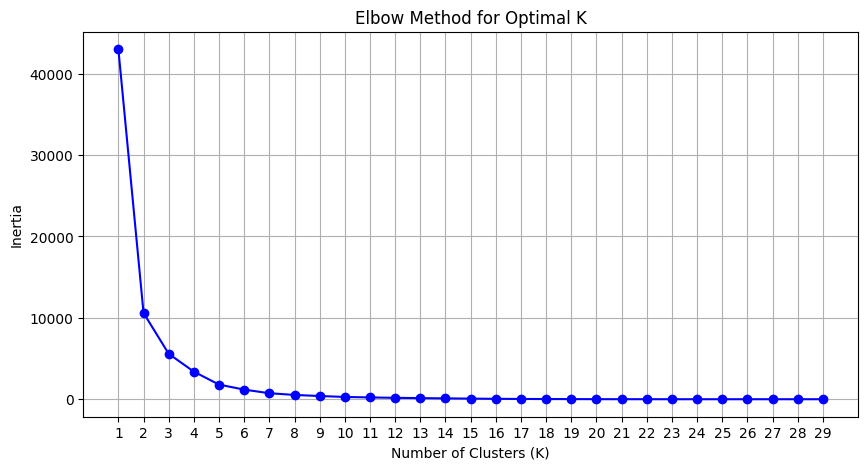

In [6]:
show_kmeans_elbow_graph(similarities)

inertia values for word2Vec start to level off around K = 4

d:\Projects\repos\pitchedit\venv_pitchedit\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


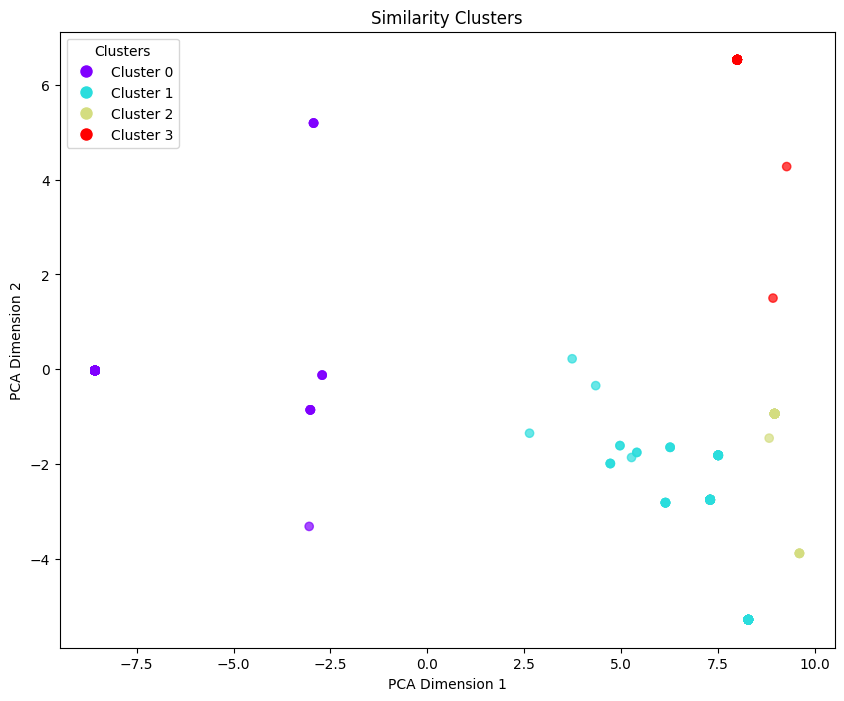

k: 4
{0: 'SaaS', 1: 'Marketplace', 2: 'E-commerce', 3: 'App'}


In [7]:
kmclusters, cluster_labels = generate_business_clusters(sims=similarities, k=4)
# Define the category names
"""
cluster_labels = {
asked chatgpt to provide names for these clusters:
    0: 'Technology and Software',
    1: 'Healthcare and Biotechnology',
    2: 'Retail and Consumer',
    3: 'Entertainment and Social Media',
    4: 'Data and Analytics', 
    5: 'Financial Services', 
}
"""

label_mapping = map_businesses_to_business_models(cluster_labels, kmclusters)

In [8]:
# Add a new column "Sector" based on the mapping
df['Business'] = df['Business Model'].map(label_mapping)

# Print the first few rows of the DataFrame to verify the new column
df.head()

,Name,Description,Sector,Business Model,Customer,Round,AmountRaised,Investor,Year,Links,Location,Business
0,Airbnb,Airbnb is an online marketplace for people to ...,2,Marketplace,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']",Marketplace
1,Alan,Alan is a platform that uses technology to mak...,1,App,B2B,Series C,$54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']",App
2,Apptopia,Apptopia serves the mobile industry with an ar...,0,Subscription,B2B,Series A,$1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']",Marketplace
3,Beatdapp,Beatdapp provides real-time tracking of media ...,3,SaaS,B2B,Seed,$2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']",SaaS
4,Bind,"Bind provides personalized, cost-transparent a...",5,Subscription,"B2C, B2B",Series A,$60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']",Marketplace


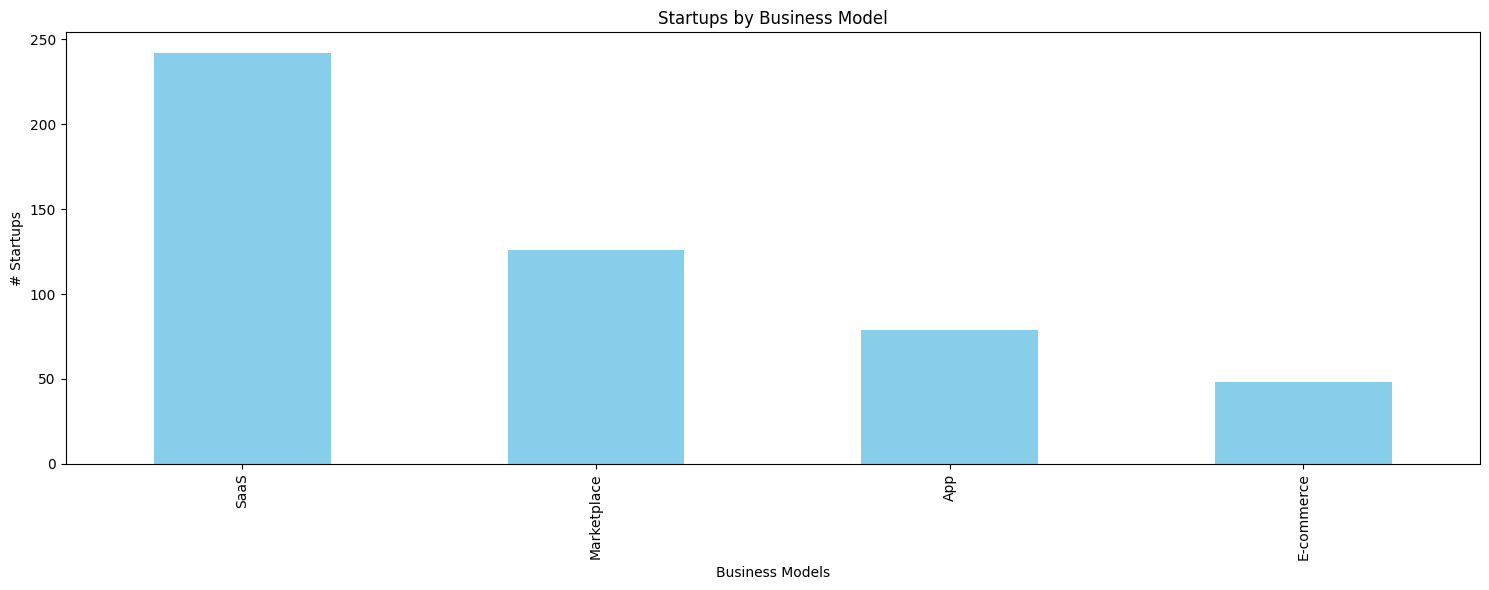

In [9]:
sector_counts = df['Business'].value_counts()

# Create a bar chart
plt.figure(figsize=(15, 6))
sector_counts.plot(kind='bar', color='skyblue')

# Set plot labels and title
plt.title('Startups by Business Model')
plt.xlabel('Business Models')
plt.ylabel('# Startups')

# Wrap x-axis labels for better readability
plt.xticks(rotation=90)  # Set rotation to 0 degrees

# Display the bar chart
plt.tight_layout()
plt.show()

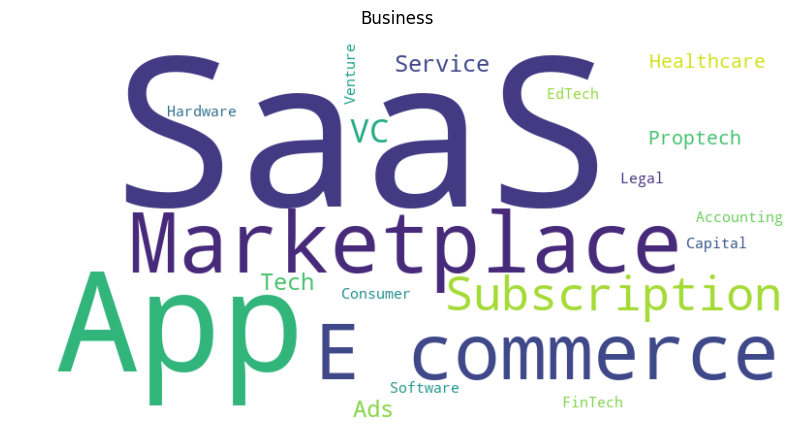

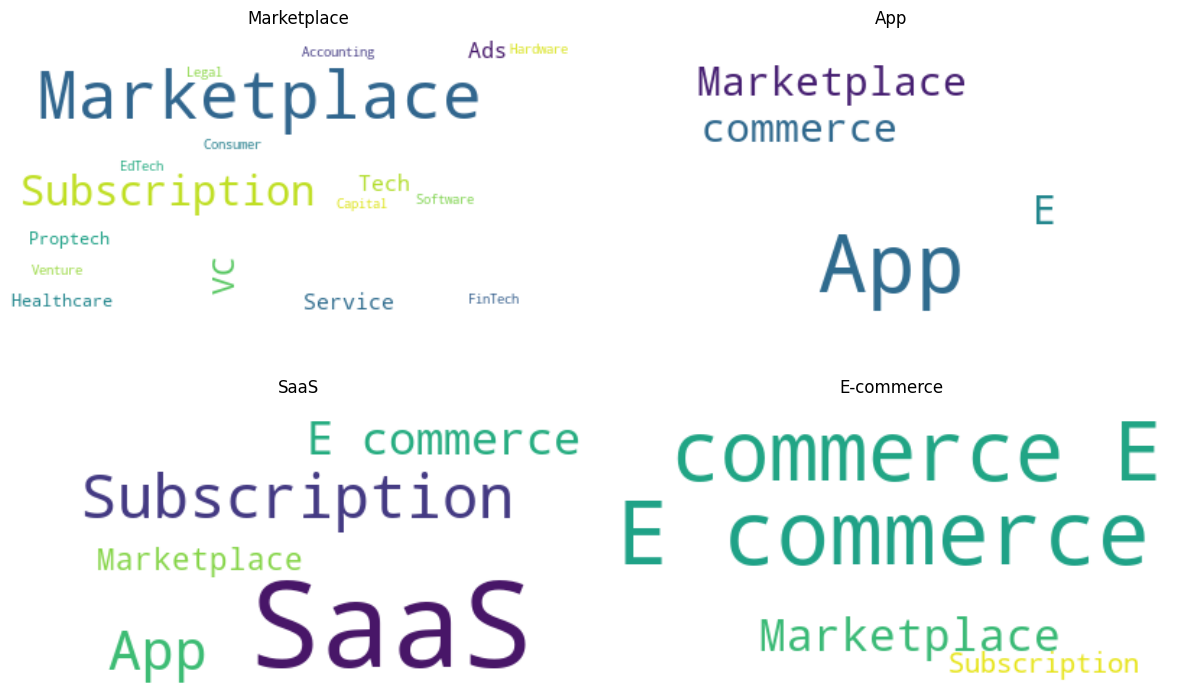

In [10]:
show_business_models_and_businesses_wordcloud(df)

In [11]:
print(cluster_labels)

{0: 'SaaS', 1: 'Marketplace', 2: 'E-commerce', 3: 'App'}


In [12]:
reverse_cluster_labels = {v: k for k, v in cluster_labels.items()}

# Replace sector names with cluster labels
df['Business'] = df['Business'].replace(reverse_cluster_labels)

In [13]:
df.drop('Business Model', axis=1, inplace=True)
# Assuming you have a DataFrame 'df' with the original column order
df = df[['Name', 'Description', 'Sector', 'Business', 'Customer', 'Round', 'AmountRaised', 'Investor', 'Year', 'Links', 'Location']]

In [14]:
df.head()

,Name,Description,Sector,Business,Customer,Round,AmountRaised,Investor,Year,Links,Location
0,Airbnb,Airbnb is an online marketplace for people to ...,2,1,"B2C, B2B",Seed,$600K,"VC, Angel Investors",2008,"['https://airbnb.com/', 'https://www.crunchbas...","['San Francisco', 'California', 'United States']"
1,Alan,Alan is a platform that uses technology to mak...,1,3,B2B,Series C,$54M,VC,2020,"['https://alan.com/', 'https://www.crunchbase....","['Paris', 'Ile-de-France', 'France']"
2,Apptopia,Apptopia serves the mobile industry with an ar...,0,1,B2B,Series A,$1.46M,VC,2018,"['http://www.apptopia.com/', 'https://www.crun...","['Boston', 'Massachusetts', 'United States']"
3,Beatdapp,Beatdapp provides real-time tracking of media ...,3,0,B2B,Seed,$2.4M,VC,2019,"['https://beatdapp.com/', 'https://www.crunchb...","['Vancouver', 'British Columbia', 'Canada']"
4,Bind,"Bind provides personalized, cost-transparent a...",5,1,"B2C, B2B",Series A,$60M,VC,2018,"['https://www.yourbind.com/', 'https://www.cru...","['Minneapolis', 'Minnesota', 'United States']"


### save cleaned dataset

In [15]:
# Save the updated DataFrame to a new CSV file or overwrite the original one
df.to_csv('data/falory_clean_business_model.csv', index=False)